In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as st
from matplotlib.ticker import FuncFormatter

matplotlib. rcParams['font.family']='SimHei'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
sto_vol_df=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\(stochastic vol) VaR and Sigma of 2020.xlsx',index_col='date')
other_VaR_df=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Other VaR Measures.xlsx',index_col='date')

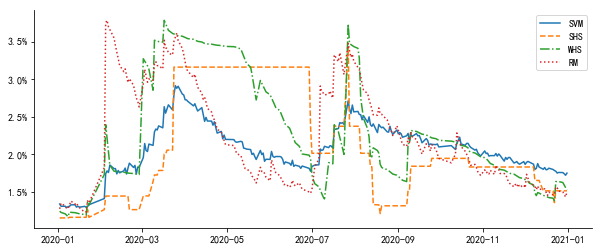

In [8]:
fig,ax=plt.subplots(figsize=(10, 4))

ax.plot(sto_vol_df.index,sto_vol_df['VaR'],label='SVM')
ax.plot(other_VaR_df.index,other_VaR_df['SHS'],linestyle='--',label='SHS')
ax.plot(other_VaR_df.index,other_VaR_df['WHS'],linestyle='-.',label='WHS')
ax.plot(other_VaR_df.index,other_VaR_df['RM'],linestyle=':',label='RM')

def to_percent(temp, position):
    return '%0.1f'%(100*temp) + '%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

ax.legend()
plt.show()

fig.savefig('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\figures\\VaR of 2020.pdf',bb_inches='tight')

## Evaluation 1: Testing Breaches

In [65]:
num=len(sto_vol_df)
breach_time=(sto_vol_df['Market Returns']<(-sto_vol_df['VaR'])).sum()
binomial=st.binom(num, 0.05)
prob=binomial.pmf(breach_time)
p_value=binomial.cdf(breach_time)*2

table=pd.DataFrame()
table['Sto_Vol']=[int(breach_time),'%.2f'%(100*prob)+'%','%.2f'%(100*p_value)+'%']
table.index=['Breach Times','Probability','P-Value']

for ii in ['SHS','WHS','RM']:
    breach_time=(sto_vol_df['Market Returns']<(-other_VaR_df[ii])).sum()
    prob=binomial.pmf(breach_time)
    
    if breach_time<int(num*0.05):
        p_value=binomial.cdf(breach_time)*2
    else:
        p_value=(1-binomial.cdf(breach_time))*2
    
    table[ii]=[int(breach_time),'%.2f'%(100*prob)+'%','%.2f'%(100*p_value)+'%']

In [66]:
table

,Sto_Vol,SHS,WHS,RM
Breach Times,11,17,12,13
Probability,11.52%,4.01%,11.72%,10.96%
P-Value,88.24%,12.77%,88.32%,66.40%


In [67]:
table.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Testing Breaches.xlsx',encoding='utf-8',index=True,header=True)

## Evaluation 2: Cumulative Profitability

In [68]:
import baostock as bs

In [69]:
#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

df=pd.DataFrame()

code='sh.000300'
name='沪深300'

#### 获取沪深A股历史K线数据 ####
rs = bs.query_history_k_data_plus(code,"date,code,open",
    start_date='2005-01-01', end_date='2020-12-31',
    frequency="d", adjustflag="2")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

df[name]=result['open']

print('%s is finished'%name)

df['date']=result['date']

#### 登出系统 ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
沪深300 is finished
logout success!


In [71]:
df['date']=pd.to_datetime(df['date'])
df['沪深300']=pd.to_numeric(df['沪深300'])
df=df.set_index('date')
df.columns=['Open']

In [76]:
df_close=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\sh300.xlsx',index_col='date')
df_close.columns=['Close']
stock_price=pd.concat([df,df_close],axis=1)
stock_price.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\sh300.xlsx',encoding='utf-8',index=True,header=True)

In [5]:
stock_price=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\sh300.xlsx',index_col='date')

In [6]:
return_within_day=(np.log(stock_price['Close'])-np.log(stock_price['Open']))
other_VaR_df['sto_vol']=sto_vol_df['VaR']
P_and_L_cumulative=other_VaR_df.apply(lambda x:(((1000000/x)*return_within_day.loc['2020']).cumsum())/1000)
P_and_L_one_day=other_VaR_df.apply(lambda x:((1000000/x)*return_within_day.loc['2020'])/1000)

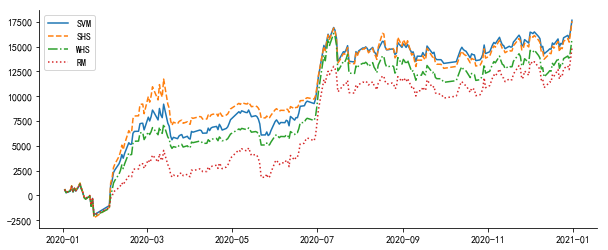

In [16]:
fig,ax=plt.subplots(figsize=(10, 4))

ax.plot(P_and_L_cumulative.index,P_and_L_cumulative['sto_vol'],label='SVM')
ax.plot(P_and_L_cumulative.index,P_and_L_cumulative['SHS'],linestyle='--',label='SHS')
ax.plot(P_and_L_cumulative.index,P_and_L_cumulative['WHS'],linestyle='-.',label='WHS')
ax.plot(P_and_L_cumulative.index,P_and_L_cumulative['RM'],linestyle=':',label='RM')
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
ax.legend()

plt.show()

fig.savefig('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\figures\\Cumulative P&L.pdf',bb_inches='tight')